#  Movielens 영화 SBR

## Data load

데이터를 불러와 살펴보고 주요 통계치들을 살펴봅시다.

In [148]:
import datetime as dt
from pathlib import Path

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [149]:
data_path = Path('/content/drive/MyDrive/Colab/yoochoose/data')
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
orginal_data_size = len(data)
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

위와 같은 정보를 바탕으로 오늘의 실습과정과 유사한 프로젝트 과정을 진행해 보겠습니다.


## Step 1. 데이터의 전처리
위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.

특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

~# rating이 3 미만인 값은 해당 이용자의 선호도가 낮은것이므로~
~# 추천 하기엔 적합하지 않은 대상으로 판단하고 삭제~

~# 3점 이상만 남깁니다.
data = data[data['Rating']>=3]
filtered_data_size = len(data)~

~print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')~

~data~

~유저id를 세션id로 쓰려고 했더니 이후에 데이터셋 나누는 구간에서 말도 안되는 결과가 나옴
그렇다고 timestamp를 그대로 쓰자니 초단위의 세션은 말도 안되고.
영화는 쇼핑보다는 연속성이 좀 더 있을 것 같아서
유저 아이디 하나당 1개월단위를 하나의 세션으로 만들어보자~

월별, 일별에서 결과가 영 나오지 않아서 초 당으로 나눈 세션을 사용하기로 함

In [150]:
# Time에서 연 월 정보 획득해서 Session컬럼 생성

# 월별
#data['Session'] = data['Time'].apply(lambda s : dt.datetime.fromtimestamp(int(s)).strftime('%Y-%m'))
# 일별
#data['Session'] = data['Time'].apply(lambda s : dt.datetime.fromtimestamp(int(s)).strftime('%Y-%m-%d'))
# 초별
data['Session'] = data['Time'].apply(lambda s : str(s))

# Time 컬럼의 형식 변경
data['Time'] = data['Time'].apply(lambda s : dt.datetime.fromtimestamp(int(s)))
data.head()

,UserId,ItemId,Rating,Time,Session
31,1,3186,4,2000-12-31 22:00:19,978300019
22,1,1270,5,2000-12-31 22:00:55,978300055
27,1,1721,4,2000-12-31 22:00:55,978300055
37,1,1022,5,2000-12-31 22:00:55,978300055
24,1,2340,3,2000-12-31 22:01:43,978300103


In [151]:
# UserId 와 Session이 동일한 행만 인덱싱하기 위해
# 두 칼럼을 붙여서 SessionId 컬럼을 만든다

data['SessionId'] = data.apply(lambda x: str(x['UserId'])+'/'+x['Session'], axis=1)
data.head()

,UserId,ItemId,Rating,Time,Session,SessionId
31,1,3186,4,2000-12-31 22:00:19,978300019,1/978300019
22,1,1270,5,2000-12-31 22:00:55,978300055,1/978300055
27,1,1721,4,2000-12-31 22:00:55,978300055,1/978300055
37,1,1022,5,2000-12-31 22:00:55,978300055,1/978300055
24,1,2340,3,2000-12-31 22:01:43,978300103,1/978300103


In [152]:
# SessionId 를 기준으로 다시 인덱싱

sessionid_unique = data['SessionId'].unique()
sessionid_dic = {v:k for k,v in enumerate(sessionid_unique)}

sessionid_idx = data['SessionId'].map(sessionid_dic.get).dropna()
if len(sessionid_idx) == len(data):   # 모든 row가 정상적으로 인덱싱되었다면
    print('SessionId column indexing OK!!')
    data['SessionId'] = sessionid_idx   # data['SessionId']을 인덱싱된 Series로 교체해 줍니다. 
else:
    print('user_id column indexing Fail!!')

data.head()

SessionId column indexing OK!!


,UserId,ItemId,Rating,Time,Session,SessionId
31,1,3186,4,2000-12-31 22:00:19,978300019,0
22,1,1270,5,2000-12-31 22:00:55,978300055,1
27,1,1721,4,2000-12-31 22:00:55,978300055,1
37,1,1022,5,2000-12-31 22:00:55,978300055,1
24,1,2340,3,2000-12-31 22:01:43,978300103,2


In [153]:
# 세션 수와 아이템 수 확인
data['SessionId'].nunique(), data['ItemId'].nunique()

(471163, 3706)

In [154]:
# 세션 별 별점 횟수 확인

action_per_session = data.groupby('Session').size()
action_per_session

Session
1000006356    1
1000038811    1
1000056458    1
1000056597    1
1000056819    1
             ..
999974059     1
999974100     4
999977333     1
999991950     1
999995338     1
Length: 458455, dtype: int64

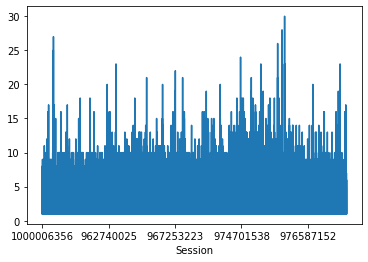

In [155]:
action_per_session.plot()

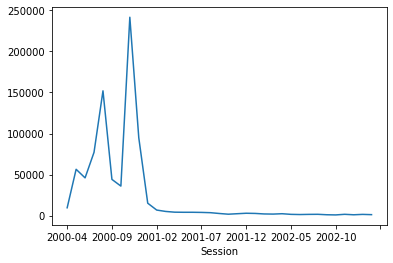

월별로 확인했을 때 2000년 8월과 11월에 유난히 튀는 피크가 있었다.

이 시기에 이벤트라도 했던 것 같은데 좀 찝찝한 분포..

In [156]:
# 쓰지 않을 컬럼 삭제하고 순서 변경

data = data[['SessionId', 'ItemId', 'Time']]
data.head()

,SessionId,ItemId,Time
31,0,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,2,2340,2000-12-31 22:01:43


## Session Overview

각 세션이 대략 몇 개의 클릭 데이터를 갖는지도 살펴보겠습니다.

여기서 session_length란 같은 SessionId를 공유하는 데이터 row의 개수를 의미합니다.

따라서 여기서 session_length란 해당 세션의 사용자가 그 세션 동안 몇번의 액션을 취했는지(몇개의 영화의 별점을 남겼는지)의 의미가 됩니다.

In [157]:
# 세션 길이 확인
session_length = data.groupby('SessionId').size()
session_length

SessionId
0         1
1         3
2         1
3         1
4         1
         ..
471158    1
471159    1
471160    2
471161    1
471162    1
Length: 471163, dtype: int64

In [158]:
# 중앙값과 평균값 확인
session_length.median(), session_length.mean()

(2.0, 2.1228513274599234)

In [159]:
# 최솟값과 최댓값 확인
session_length.min(), session_length.max()

(1, 30)

In [160]:
# 99.9%까지의 값 확인
session_length.quantile(0.999)

10.0

In [161]:
# 별점 준 횟수 별 세션 수 확인
length_count = session_length.groupby(session_length).size()
length_count

1     226181
2     110199
3      62860
4      34081
5      18354
6       9656
7       5013
8       2458
9       1232
10       661
11       106
12        83
13        85
14        48
15        38
16        29
17        16
18        13
19         9
20        14
21         6
22         7
23         5
25         2
26         2
27         2
28         2
30         1
dtype: int64

# 세션 길이가 긴 경우를 확인하기 위한 함수
``` python
def long_session(len):
    long_session = session_length[session_length==len].index[0]
    return data[data['SessionId']==long_session]
```

In [162]:
# 한달동안 1500개 이상의 별점을 주는 사람은 뭐하는 사람인지 확인

# 한달 간격으로 체크했었으나 폐기함

# long_session(1515)

~분명히 세션을 한달 간격으로 잘랐는데 이틀동안 천오백개의 액션을 했다는건, 그동안 보았던 영화에 대해서 숙제하듯이 별점을 매겼다는건데...~

~일정 시간 동안 연속된 행동을 바탕으로 다음에 볼 영화를 추천하는 시스템에서~

~이렇게 과거기억을 때려넣는 게 바람직한지 고민할 필요가 있을 것 같아서 몇개 더 확인.~

~길이가 가장 긴 세션은 11월, 1000 이상의 길이를 갖는 3개는 8월의 데이터이다.~

~아무래도 이 시기의 데이터는 신뢰하기가 힘들 것 같다.~

~데이터 수가 아주 많이 잘려나가겠지만 마지막 날짜 기준 최근 2년의 데이터만 활용하기로 결정했으나~

~너무 많이 잘라서인지 학습이 제대로 되지 않아서 이상치를 제거하는 방향으로 선회~


In [163]:
# 세션 길이 기준 99.9% 까지의 누적합 구하기

length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum <= 0.999]

length_percent_cumsum_999

1    0.480048
2    0.713936
3    0.847350
4    0.919684
5    0.958639
6    0.979132
7    0.989772
8    0.994989
9    0.997604
dtype: float64

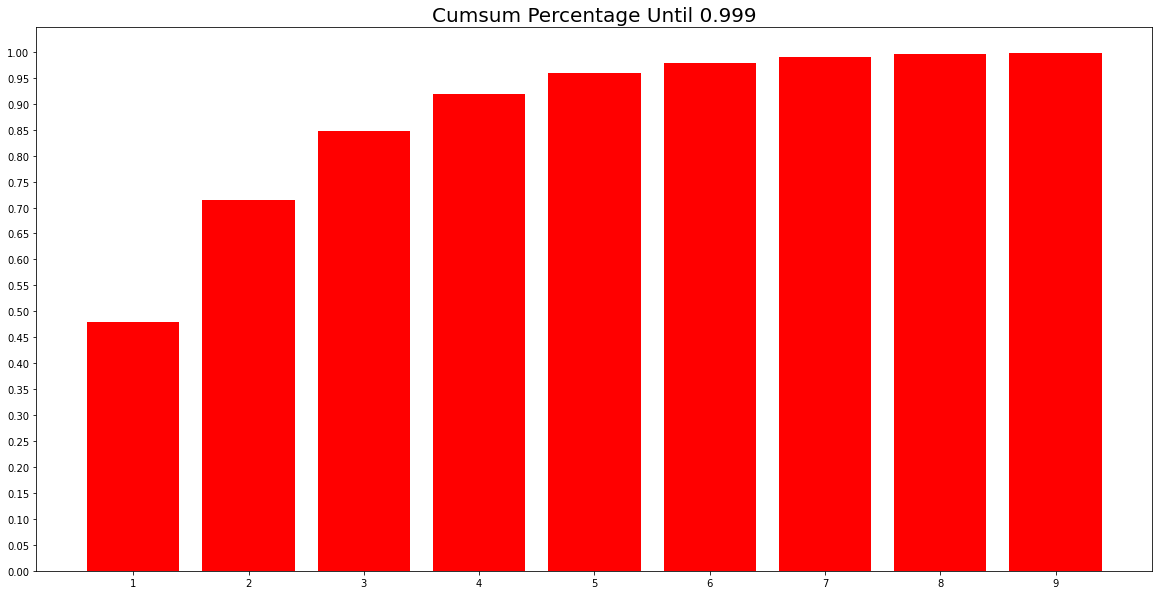

In [164]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()


## Session Time

데이터의 시간 관련 정보를 확인해 보자.

In [165]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


~약 3년간의 데이터가 있는데 영화 소비의 패턴은 쇼핑 트렌드만큼 빨리 바뀌지는 않을 것이므로 3년치를 다 쓰려고 했었으나 데이터 상태가 별로라 2년치를 잘라서 쓰기로 결정~

날짜끼리 차이를 구하기 위해 datetime 라이브러리의 timedelta 사용
```
month_ago = latest - dt.timedelta(730)     # 최종 날짜로부터 2년 이전 날짜를 구한다.  
data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data
```

-> 폐기

## Data Cleansing

너무 적게 클릭된 영화 체크

In [166]:
# 영화마다 별점 받은 횟수 확인하기

item_length = data.groupby('ItemId').size()
item_length

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

In [167]:
# 별점 받은 횟수 별 영화 개수

length2_count = item_length.groupby(item_length).size()
length2_count

1       114
2        89
3        42
4        45
5        39
       ... 
2672      1
2883      1
2990      1
2991      1
3428      1
Length: 924, dtype: int64

In [168]:
only_one, rare, all_data = length2_count[1], length2_count[:6].sum(), len(item_length)
print(f'{only_one}, {rare}, {all_data}')
print(f'Ratio of only_one over all data is {only_one/all_data:.2%}')
print(f'Ratio of rare_movie over all data is {rare/all_data:.2%}') 

114, 356, 3706
Ratio of only_one over all data is 3.08%
Ratio of rare_movie over all data is 9.61%


5회 이하로 클릭 되었다고 지워버리면 전체 데이터의 1/10이 날아가버리는데 지우면 안될 것 같다

별점을 1번만 받은, 즉 실습에서로 따지면 딱 한번만 클릭 된 영화가 전체의 3% 정도인데

삭제할까 하다가 일단 남겨두기로 결정

In [169]:
# 세션 길이 다시 확인
session_length = data.groupby('SessionId').size()
length_count = session_length.groupby(session_length).size()
length_count

1     226181
2     110199
3      62860
4      34081
5      18354
6       9656
7       5013
8       2458
9       1232
10       661
11       106
12        83
13        85
14        48
15        38
16        29
17        16
18        13
19         9
20        14
21         6
22         7
23         5
25         2
26         2
27         2
28         2
30         1
dtype: int64

유저가 최소 1개 이상 클릭했을 때 다음 클릭을 예측하는 것이므로 길이가 1인 세션은 제거

1초만에 너무 많은 액션을 한 세션(99.9%를 넘는 경우)도 이상치로 보고 제거

In [170]:
session_use1 = session_length[session_length > 1].index
data = data[data['SessionId'].isin(session_use1)]

session_use2 = session_length[session_length <= session_length.quantile(0.999)].index
data = data[data['SessionId'].isin(session_use2)]

session_length = data.groupby('SessionId').size()
length_count = session_length.groupby(session_length).size()
length_count

2     110199
3      62860
4      34081
5      18354
6       9656
7       5013
8       2458
9       1232
10       661
dtype: int64

In [171]:
data

,SessionId,ItemId,Time
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
7,5,2804,2000-12-31 22:11:59
47,5,1207,2000-12-31 22:11:59
...,...,...,...
1000162,471145,3362,2001-08-10 14:29:56
999917,471146,3421,2001-08-10 14:31:49
1000069,471146,1258,2001-08-10 14:31:49
999988,471160,1921,2001-08-10 14:41:04


## Step 2. 미니 배치의 구성
실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.

단, 위 Step 1에서 Session 단위를 어떻게 정의했느냐에 따라서 Session-Parallel Mini-Batch이 굳이 필요하지 않을 수도 있습니다.

### Train/ Valid/ Test split

검증세트와 테스트 세트 나누기

마지막 1개월을 test, 그 전 3개월을 val로 나누자

In [172]:
# 데이터 셋 분리
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    session_last_time = data.groupby('SessionId')['Time'].max()
    session_in_train = session_last_time[session_last_time < final_time - dt.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time >= final_time - dt.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

# 데이터 정보 확인
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [173]:
tr, test = split_by_date(data, n_days=31) 
tr, val = split_by_date(tr, n_days=91)

stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 764257
	 Sessions: 243295
	 Items: 3654
	 First Time : 2000-04-25 23:05:54
	 Last Time : 2002-10-27 13:41:27

* valid Set Stats Info
	 Events: 2210
	 Sessions: 835
	 Items: 1197
	 First Time : 2002-10-28 00:38:30
	 Last Time : 2003-01-26 18:45:41

* test Set Stats Info
	 Events: 994
	 Sessions: 384
	 Items: 762
	 First Time : 2003-01-28 18:41:15
	 Last Time : 2003-02-28 17:49:08



In [174]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

save_path = data_path / 'processed2'
save_path.mkdir(parents=True, exist_ok=True)

tr.to_pickle(save_path / 'train.pkl')
val.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

### Data Pipeline

####SessionDataset
데이터가 주어지면 세션이 시작되는 인덱스를 담는 값과 세션을 새로 인덱싱한 값을 갖는 클래스를 만듭니다.

In [175]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [176]:
# SessionDataset 객체 만들기

tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

,SessionId,ItemId,Time,item_idx
22,1,1270,2000-12-31 22:00:55,0
27,1,1721,2000-12-31 22:00:55,1
37,1,1022,2000-12-31 22:00:55,2
7,5,2804,2000-12-31 22:11:59,3
47,5,1207,2000-12-31 22:11:59,4
0,6,1193,2000-12-31 22:12:40,5
21,6,720,2000-12-31 22:12:40,6
44,6,260,2000-12-31 22:12:40,7
14,14,1035,2000-12-31 22:29:13,8
42,14,1962,2000-12-31 22:29:13,9


#### SessionDataLoader

`SessionDataset` 객체를 받아서 Session-Parallel mini-batch를 만드는 클래스를 만듭니다.
`__iter__` 메소드는 모델 인풋, 라벨, 세션이 끝나는 곳의 위치를 `yield`합니다.
mask는 후에 RNN Cell State를 초기화 하는데 사용할 것입니다.

In [177]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

## Step 3. 모델 구성
### Evaluation Metric
모델 성능 평가를 위한 지표를 보겠습니다. \
모델 성능에 대한 지표로 precision이나 recall이 있습니다. \
Session-Based Recommendation Task에서는 모델이 k개의 아이템을 제시했을 때, 유저가 클릭/ 구매한 n개의 아이템이 많아야 좋습니다. \
이 때문에 recall의 개념을 확장한 `recall@k` 지표, precision의 개념을 확장한 `Mean Average Precision@k` 지표 등을 사용합니다. \
추천에서는 몇 번째로 맞추느냐도 중요합니다. 구글에서 검색했을 때 1페이지에 원하는 결과가 나오지 않고 2페이지에 나온다면 유저 반응이 크게 떨어질 것입니다. \
따라서 순서에 민감한 지표인 `MRR`, `NDCG` 같은 지표도 사용합니다. \
이번 자료에서는 `MRR`과 `Recall@k`를 사용하겠습니다. `MRR`은 정답 아이템이 나온 순번의 역수 값입니다. \
따라서 정답 아이템이 추천 결과 앞쪽 순번에 나온다면 지표가 높아질 것이고 뒤쪽에 나오거나 안나온다면 지표가 낮아질 것입니다.

In [178]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

### Model Architecture

In [179]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [180]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [181]:
# 하이퍼파라미터를 클래스로 관리

class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.4, lr=0.001, epochs=10, k=20)

In [182]:
model = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(128, 1, 3654)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 50), (128, 50)]    555900    
_________________________________________________________________
dropout_3 (Dropout)          (128, 50)                 0         
_________________________________________________________________
dense_3 (Dense)              (128, 3654)               186354    
Total params: 742,254
Trainable params: 742,254
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습
다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.

In [183]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [184]:
# 학습 시간이 다소 오래 소요됩니다. (예상시간 1시간)
train_model(model, args)

Evaluation:  90%|█████████ | 9/10 [00:06<00:00,  1.38it/s]


	 - Recall@20 epoch 1: 0.092882
	 - MRR@20    epoch 1: 0.023308



Evaluation:  90%|█████████ | 9/10 [00:06<00:00,  1.47it/s]


	 - Recall@20 epoch 2: 0.176215
	 - MRR@20    epoch 2: 0.058151



Evaluation:  90%|█████████ | 9/10 [00:05<00:00,  1.54it/s]


	 - Recall@20 epoch 3: 0.214410
	 - MRR@20    epoch 3: 0.071617



Evaluation:  90%|█████████ | 9/10 [00:05<00:00,  1.59it/s]


	 - Recall@20 epoch 4: 0.218750
	 - MRR@20    epoch 4: 0.076815



Evaluation:  90%|█████████ | 9/10 [00:05<00:00,  1.53it/s]


	 - Recall@20 epoch 5: 0.223958
	 - MRR@20    epoch 5: 0.083132



Evaluation:  90%|█████████ | 9/10 [00:05<00:00,  1.61it/s]


	 - Recall@20 epoch 6: 0.230035
	 - MRR@20    epoch 6: 0.085539



Evaluation:  90%|█████████ | 9/10 [00:05<00:00,  1.59it/s]


	 - Recall@20 epoch 7: 0.233507
	 - MRR@20    epoch 7: 0.085197



Evaluation:  90%|█████████ | 9/10 [00:05<00:00,  1.63it/s]


	 - Recall@20 epoch 8: 0.232639
	 - MRR@20    epoch 8: 0.088125



Evaluation:  90%|█████████ | 9/10 [00:05<00:00,  1.58it/s]


	 - Recall@20 epoch 9: 0.237847
	 - MRR@20    epoch 9: 0.089754



Evaluation:  90%|█████████ | 9/10 [00:05<00:00,  1.60it/s]

	 - Recall@20 epoch 10: 0.239583
	 - MRR@20    epoch 10: 0.088842



## Step 5. 모델 테스트
미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [187]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print()
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 100%|██████████| 4/4 [00:02<00:00,  1.49it/s]


	 - Recall@20: 0.191406
	 - MRR@20: 0.072560



### 테스트 했던 과정들

중간중간 val과 test set을 조절했던 것 같은데 체크를 못했다 ㅠㅠ

세션: 월별, drop_rate=0.4, lr=0.01, epochs=20

20 에폭동안 수치가 별로 나아지지 않음

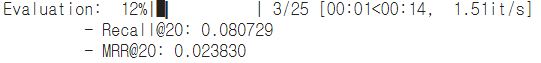

세션: 월별, drop_rate=0.4, lr=0.01, epochs=10, 3점 이상만, 이상치 제거
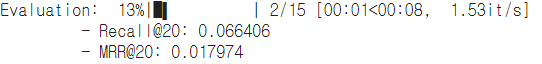

세션: 일별, drop_rate=0.4, lr=0.01, epochs=10

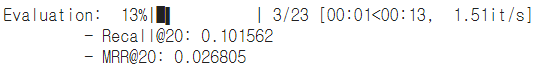



세션: 초별, drop_rate=0.4, lr=0.01, epochs=10
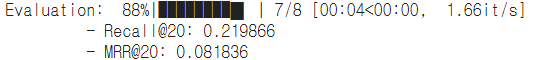

세션: 초별, drop_rate=0.4, lr=0.01, epochs=10, batch size=512

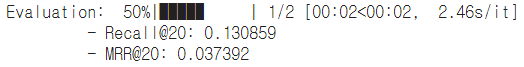

세션: 초별, drop_rate=0.4, lr=0.01, epochs=10, batch size=256, 3점 이상만, 이상치 제거
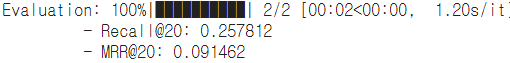

세션: 초별, drop_rate=0.4, lr=0.001, epochs=10, batch size=256, 3점 이상만, 이상치 제거
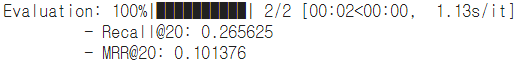

세션: 초별, drop_rate=0.4, lr=0.001, epochs=10, batch size=32, 3점 이상만, 이상치 제거

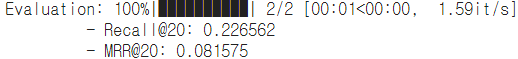

세션: 초별, drop_rate=0.4, lr=0.001, epochs=10, batch size=32, 3년 전체, 3점 이상만, 이상치 제거

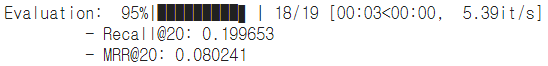

세션: 초별, drop_rate=0.4, lr=0.001, epochs=10, batch size=256, 3년 전체, 3점 이상만, 이상치 제거

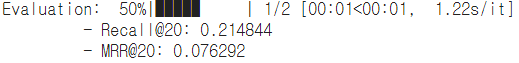

# 회고

세션베이스가 아닌걸 세션베이스로 맞추려고 해서 그런지 상태가 영 안좋다...

많이 조절을 해보았는데 30퍼센트도 맞추기가 힘들었고..

나름대로 변수를 해석해서 정리를 해보려고 했는데 결과가 더 안 나오니까 기운빠진다 ㅠㅠ